**Input Speech Signal**

In [26]:
#collapse
import numpy as np
import librosa
import os
from IPython.lib.display import Audio
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.decomposition import PCA


import seaborn as sns

fs = 16000
from google.colab import drive
drive.mount('/content/gdrive')
# load
x, sr = librosa.load('/content/gdrive/MyDrive/content/sample_data/audio_sample.wav',sr=fs)
x = x/max(np.abs(x))
times = np.arange(0,len(x))/sr
# listen
Audio(x, rate=sr, autoplay=False)



Mounted at /content/gdrive


**Representation of Signal**

Nos. samples: 27133
Duration: 1.69575seconds


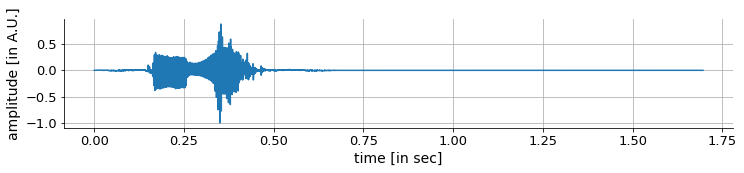

In [28]:
#collapse
# plot
print('Nos. samples: '+str(len(x)))
print('Duration: '+str(times[-1])+ 'seconds')

fig = plt.subplots(figsize=(12,2))
ax = plt.subplot(1,1,1)
ax.plot(times, x)
ax.grid(True)
plt.ylabel('amplitude [in A.U.]', fontsize=14)
plt.xlabel('time [in sec]', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

**Windowing with** **Hamming**

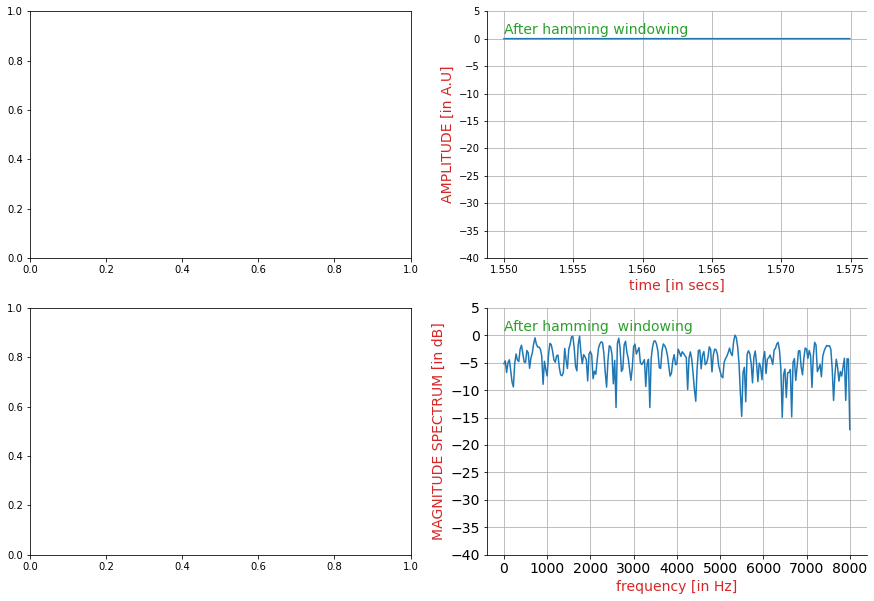

In [29]:
#collapse 
def segment_signal(signal, winType='hamming', winDur = 25e-3, hopDur=10e-3, sr=16e3):
    # hop_size in ms
    winLen = int(winDur*sr)
    hopLen = int(hopDur*sr)
    signal = np.pad(signal, winLen//2, mode='reflect')
    
    nframes = int((len(signal) - winLen) / hopLen) + 1
    frames = np.zeros((nframes,winLen))
    if winType == 'hamming':
        window = np.hamming(winLen)
        window = window-np.min(window)
        window = window/np.max(window)
    
        
    for n in range(nframes):
        frames[n] = window*signal[n*hopLen:n*hopLen+winLen]
    return frames

def nearestpow2(n):
    k=1
    while n>2**k:
        k = k+1
    return 2**k

hopDur = 10e-3 #ms
winDur = 25e-3

x_segs_hamming = segment_signal(x, winType='hamming', winDur=winDur, hopDur= hopDur, sr=sr)


fix, ax = plt.subplots(2,2,figsize=(15,10))
indx = 155
nfft = nearestpow2(x_segs_hamming.shape[1])
axis_freq = np.arange(0,nfft/2+1)*sr/nfft
axis_time = indx*hopDur+np.arange(0,x_segs_hamming.shape[1],1)/sr

X_1 = 10*np.log10(np.abs(np.fft.rfft(x_segs_hamming[indx,:],nfft)))
X_1 = X_1 - np.max(X_1)

ax[0][1].plot(axis_time,x_segs_hamming[indx,:])
ax[0][1].grid(True)
ax[0][1].set_ylabel('AMPLITUDE [in A.U]', fontsize=14, color='tab:red')
ax[0][1].set_xlabel('time [in secs]', fontsize=14, color='tab:red')
plt.yticks(fontsize=14)
ax[0][1].spines['right'].set_visible(False)
ax[0][1].spines['top'].set_visible(False)
ax[0][1].text(1.55,0.8,'After hamming windowing', fontsize= 14, color='tab:green')

ax[1][1].plot(axis_freq,X_1)
ax[1][1].grid(True)
ax[1][1].set_ylabel('MAGNITUDE SPECTRUM [in dB]', fontsize=14, color='tab:red')
ax[1][1].set_xlabel('frequency [in Hz]', fontsize=14, color='tab:red')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax[1][1].spines['right'].set_visible(False)
ax[1][1].spines['top'].set_visible(False)
ax[1][1].text(1.55,0.8,'After hamming  windowing', fontsize= 14, color='tab:green')


ax[0][1].set_ylim(-40,5)
ax[1][1].set_ylim(-40,5)
plt.show()


**Plotting the Covariance Matrix**

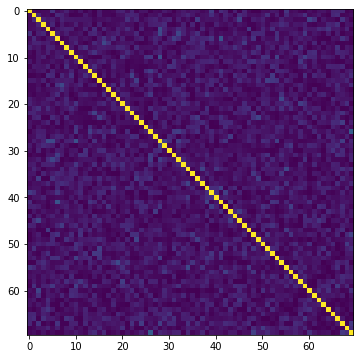

In [30]:
#collapse
x_segs = x_segs_hamming.copy()
C = np.zeros((x_segs.shape[0],x_segs.shape[0]))
#C = np.dot(x_segs.T,x_segs)
C.shape
for i in range(x_segs.shape[0]):
    for j in range(x_segs.shape[0]):
        C[i,j] = np.dot(x_segs[i,:],x_segs[j,:])/np.linalg.norm(x_segs[i,:])/np.linalg.norm(x_segs[j,:])
    
fig = plt.subplots(figsize=(12,6))
ax = plt.subplot(1,1,1)
# ax.plot(C[110,:])
ax.imshow(np.abs(C[100:200,100:200]))
plt.show()

In [31]:
#collapse
X = np.zeros((x_segs.shape[0],int(nfft/2)+1))
X = np.abs(np.fft.rfft(x_segs,nfft,axis=1))**2

**Mel-Scale Transformation of Fequencies**

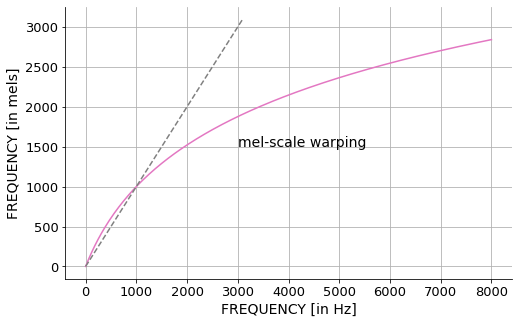

In [69]:
#collapse
def freq_to_mel(freq):
    # converting linear scale frequency to mel-scale
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def mel_to_freq(mels):
    # converting mel-scale frequency to linear scale
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

axis_freqs = np.arange(0,nfft/2+1)/nfft*sr
mels = freq_to_mel(axis_freqs)

fig = plt.subplots(figsize=[8,5])
ax = plt.subplot(1,1,1)
ax.plot(axis_freqs,mels, color='tab:pink')
ax.plot(axis_freqs[:100],axis_freqs[:100],'--',color='gray')
ax.grid(True)
ax.set_ylabel('FREQUENCY [in mels]', fontsize=14)
ax.set_xlabel('FREQUENCY [in Hz]', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.text(3000,1500,'mel-scale warping',fontsize=14)
plt.show()

**Spectral Energy Weighting Filterbank**

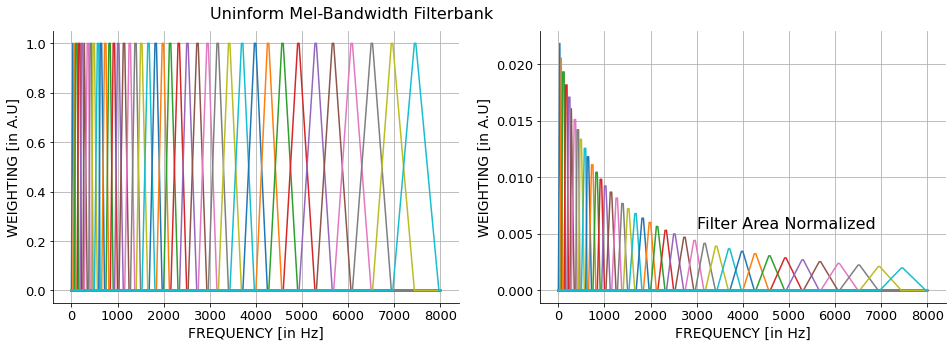

In [70]:
#collapse
freq_min = 0
freq_high = sr / 2
mel_filter_num = 40

def get_filter_points(fmin, fmax, mel_filter_num, nfft, sample_rate=16000):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = mel_to_freq(mels)
    
    return np.floor((nfft) / sample_rate * freqs).astype(int), freqs

def get_filters(filter_points, nfft):
    filters = np.zeros((len(filter_points)-2,int(nfft/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters


filter_points, freqs = get_filter_points(freq_min, freq_high, mel_filter_num, nfft=nfft, sample_rate=sr)
filters = get_filters(filter_points, nfft=nfft)

fig = plt.subplots(figsize=[16,5])
ax = plt.subplot(1,2,1)
for n in range(filters.shape[0]):
    ax.plot(axis_freqs,filters[n])
ax.grid(True)
ax.set_ylabel('WEIGHTING [in A.U]', fontsize=14)
ax.set_xlabel('FREQUENCY [in Hz]', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.text(3000,1.1,'Uninform Mel-Bandwidth Filterbank',fontsize=16)


# normalizing the filter weighting based on area
enorm = 2.0 / (freqs[2:mel_filter_num+2] - freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

ax = plt.subplot(1,2,2)
for n in range(filters.shape[0]):
    ax.plot(axis_freqs,filters[n])
ax.grid(True)
ax.set_ylabel('WEIGHTING [in A.U]', fontsize=14)
ax.set_xlabel('FREQUENCY [in Hz]', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.text(3000,.0055,'Filter Area Normalized',fontsize=16)
plt.show()

**Applying the** **Filterbank**

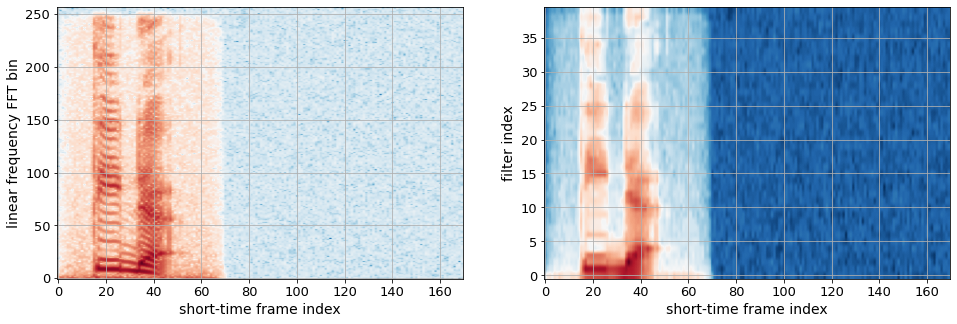

In [34]:
X_filtered = np.dot(filters, X.T)
X_filtered_log = 10.0 * np.log10(X_filtered)

fig = plt.subplots(figsize=[16,5])
ax = plt.subplot(1,2,1)
ax.imshow(10*np.log10(X.T),origin='lower',aspect='auto',cmap='RdBu_r')
ax.grid(True)
ax.set_ylabel('linear frequency FFT bin', fontsize=14)
ax.set_xlabel('', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)


ax = plt.subplot(1,2,2)
ax.imshow(X_filtered_log,origin='lower',aspect='auto',cmap='RdBu_r')
ax.grid(True)
ax.set_ylabel('filter index', fontsize=14)
ax.set_xlabel('short-time frame index', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

**Discrete Cosine Transform**

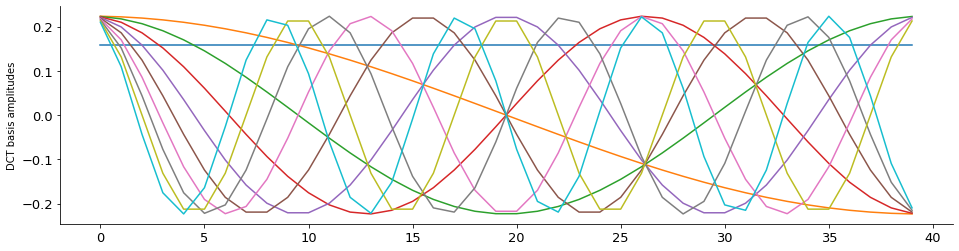

In [20]:
#collapse
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

dct_basis = dct(40,40)
fig = plt.subplots(figsize=[16,4])
ax = plt.subplot(1,1,1)
for i in range(10):
    ax.plot(dct_basis[i,:])
plt.ylabel('DCT basis amplitudes')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

**Representation of MFCC**

In [57]:
#collapse
dct_filter_num = X_scaled.shape[0]
dct_filters = dct(dct_filter_num, X_filtered_log.shape[0])
cepstral_coefficents = np.dot(dct_filters, X_filtered_log)

fig = plt.subplots(figsize=[16,5])
ax = plt.subplot(1,2,1)
ax.imshow(X_filtered_log,origin='lower',aspect='auto',cmap='RdBu_r')
ax.grid(True)
ax.set_ylabel('filter index', fontsize=14)
ax.set_xlabel('short-time frame index', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

ax = plt.subplot(1,2,2)
ax.imshow(cepstral_coefficents,origin='lower',aspect='auto',cmap='RdBu_r')
ax.grid(True)
ax.set_ylabel('MFCCs', fontsize=14)
ax.set_xlabel('short-time frame index', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

fig = plt.subplots(figsize=[16,5])
ax = plt.subplot(1,2,1)
ax.plot(cepstral_coefficents[0,:])
ax.grid(True)
ax.set_ylabel('MFCC[0]', fontsize=14)
ax.set_xlabel('short-time frame index', fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

ax = plt.subplot(1,2,2)
ax.imshow(cepstral_coefficents[1:,:],origin='lower',aspect='auto',cmap='RdBu_r')
ax.grid(True)
ax.set_ylabel('MFCCs[1:39]', fontsize=14)
ax.set_xlabel('short-time frame index', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

NameError: ignored

**Install Virtual Environment**

In [2]:
pip install virtualenv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.8 MB 5.3 MB/s 
     |████████████████████████████████| 461 kB 64.5 MB/s 


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Install Streamlit**

In [8]:
pip install streamlit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.1 MB 5.2 MB/s 
     |████████████████████████████████| 164 kB 63.5 MB/s 
     |████████████████████████████████| 77 kB 5.8 MB/s 
     |████████████████████████████████| 4.3 MB 70.0 MB/s 
     |████████████████████████████████| 181 kB 75.2 MB/s 
     |████████████████████████████████| 111 kB 65.0 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 131 kB 58.7 MB/s 
     |████████████████████████████████| 130 kB 59.6 MB/s 
     |████████████████████████████████| 428 kB 49.7 MB/s 
     |████████████████████████████████| 793 kB 51.0 MB/s 
     |████████████████████████████████| 381 kB 60.2 MB/s 
  Created wheel for blinker: filename=blinker-1.4-py3-none-any.whl size=13478 sha256=16db0d58d8aa22e7fe896fdaa84bd5a607a37c410be47af16abc850440dc4645
  Stored in directory: /root/.cache/pip/wheels/22/f5/18/df7

In [12]:
pip install flask

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
import streamlit as st

if not hasattr(st, 'already_started_server'):
    # Hack the fact that Python modules (like st) only load once to
    # keep track of whether this file already ran.
    st.already_started_server = True

st.write('''
        The first time this script executes it will run forever because it's
        running a Flask server.

        Just close this browser tab and open a new one to see your Streamlit
        app.
    ''')

    from flask import Flask

    app = Flask(__name__)

    @app.route('/foo')
    def serve_foo():
        return 'This page is served via Flask!'

    app.run(port=8888)




IndentationError: ignored

In [18]:
st.server.add_route('foo', foo_callback)

NameError: ignored